In [68]:
import awswrangler as wr
import boto3
from sklearn.ensemble import RandomForestClassifier

In [69]:
import mlflow
mlflow.sklearn.autolog()

#### Load Titanic training data set

In [70]:
boto3.setup_default_session(aws_access_key_id="-", aws_secret_access_key="-", region_name="-")
df_train = wr.s3.read_csv(path='s3://industrializing-ml-models/titanic/train.csv')

### Explore relation between class, age and survival rate

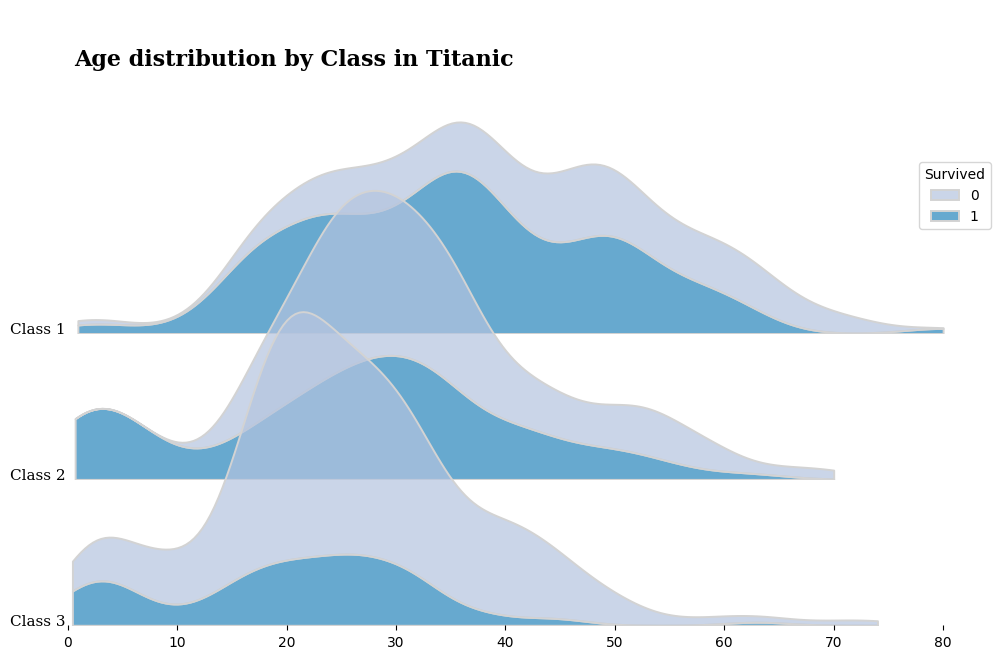

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 1)
gs.update(hspace=-0.55)

axes = list()
colors = ["#022133", "#5c693b", "#51371c"]

for idx, cls, c in zip(range(3), sorted(df_train["Class"].unique()), colors):
    axes.append(fig.add_subplot(gs[idx, 0]))

    # you can also draw density plot with matplotlib + scipy.
    sns.kdeplot(
        x="Age",
        data=df_train[df_train["Class"] == cls],
        fill=True,
        ax=axes[idx],
        cut=0,
        bw_method=0.25,
        lw=1.4,
        edgecolor="lightgray",
        hue="Survived",
        multiple="stack",
        palette="PuBu",
        alpha=0.7,
    )

    axes[idx].set_ylim(0, 0.04)
    axes[idx].set_xlim(0, 85)

    axes[idx].set_yticks([])
    if idx != 2:
        axes[idx].set_xticks([])
    axes[idx].set_ylabel("")
    axes[idx].set_xlabel("")

    spines = ["top", "right", "left", "bottom"]
    for s in spines:
        axes[idx].spines[s].set_visible(False)

    axes[idx].patch.set_alpha(0)
    axes[idx].text(
        -0.2,
        0,
        f"Class {cls}",
        fontweight="light",
        fontfamily="serif",
        fontsize=11,
        ha="right",
    )
    if idx != 1:
        axes[idx].get_legend().remove()

fig.text(
    0.13,
    0.81,
    "Age distribution by Class in Titanic",
    fontweight="bold",
    fontfamily="serif",
    fontsize=16,
)

plt.show()

#### Add Sex feature

In [72]:
sexes = sorted(df_train['Sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
df_train['Sex_Val'] = df_train['Sex'].map(genders_mapping).astype(int)

#### Add Age feature

In [73]:
df_train['AgeFill'] = df_train['Age']
df_train['AgeFill'] = df_train['AgeFill'].groupby([df_train['Sex_Val'], df_train['Class']], group_keys=False).apply(lambda x: x.fillna(x.median()))

#### Add Family Size feature

In [74]:
df_train['FamilySize'] = df_train['Siblings'] + df_train['ParentsChildren']

### Plot feature correlation matrix

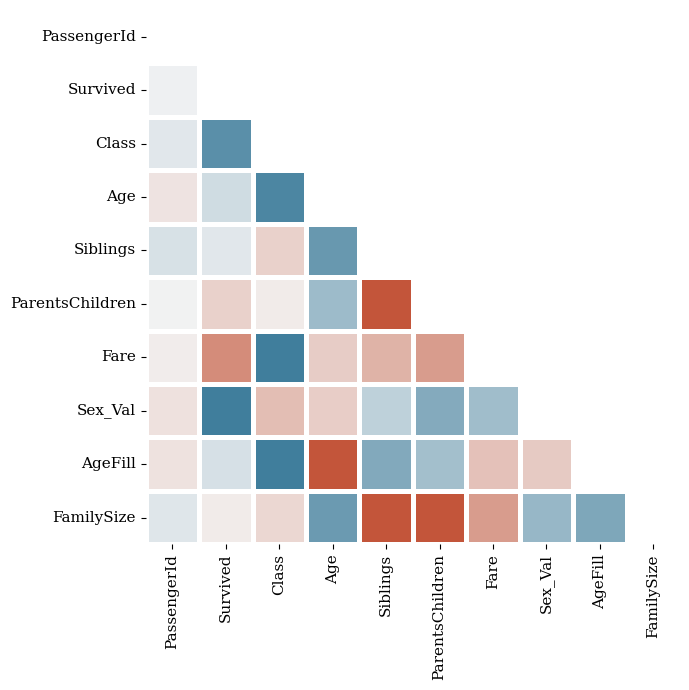

In [75]:
import numpy as np

corr = df_train.corr(numeric_only=True)
_, ax = plt.subplots(1, 1, figsize=(7, 7))

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    square=True,
    mask=mask,
    linewidth=2.5,
    vmax=0.4,
    vmin=-0.4,
    cmap=cmap,
    cbar=False,
    ax=ax,
)

ax.set_yticklabels(
    ax.get_xticklabels(), fontfamily="serif", rotation=0, fontsize=11
)
ax.set_xticklabels(
    ax.get_xticklabels(), fontfamily="serif", rotation=90, fontsize=11
)

plt.tight_layout()
plt.show()

#### Get rid of unused columns for the clasifier

In [76]:
df_train = df_train.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Siblings', 'ParentsChildren', 'Fare'], axis=1)
train_data = df_train.values[:,1:]

#### Create and train a classifier

In [77]:
classifier = RandomForestClassifier(n_estimators=100)
train_features = train_data[:, 1:]
train_target = train_data[:, 0]
classifier = classifier.fit(train_features, train_target)

2023/11/26 19:32:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ab59a66948984b08880e8f64d1b97bf4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/11/26 19:32:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/6_/bctq0wpd12xcgz6zmb4wg5vc0000gn/T/tmp5jon_1ao/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/11/26 19:32:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Lieven/Projects/DataMinded/nike/.venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


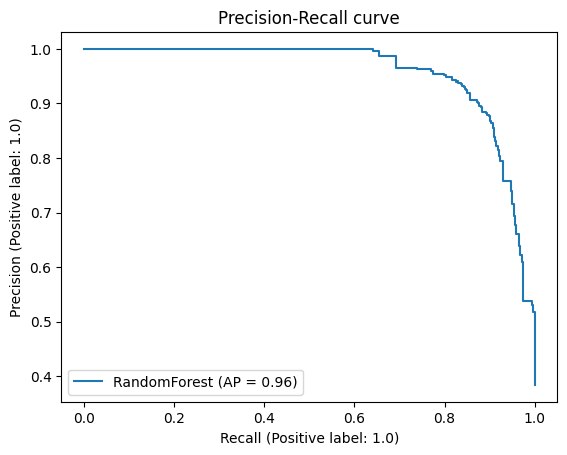

In [78]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classifier, train_features, train_target, name="RandomForest"
)
_ = display.ax_.set_title("Precision-Recall curve")

#### Load the test data set and apply the same data preparation

In [79]:
df_test = wr.s3.read_csv(path='s3://industrializing-ml-models/titanic/test.csv')
df_test['Sex_Val'] = df_test['Sex'].map(genders_mapping).astype(int)
df_test['AgeFill'] = df_test['Age']
df_test['AgeFill'] = df_test['AgeFill'].groupby([df_test['Sex_Val'], df_test['Class']], group_keys=False).apply(lambda x: x.fillna(x.median()))
df_test['FamilySize'] = df_test['Siblings'] + df_test['ParentsChildren']
df_test = df_test.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Siblings', 'ParentsChildren', 'Fare'], axis=1)
test_data = df_test.values[:,1:]

In [80]:
test_data

array([[ 3. ,  1. , 34.5,  0. ],
       [ 3. ,  0. , 47. ,  1. ],
       [ 2. ,  1. , 62. ,  0. ],
       ...,
       [ 3. ,  1. , 38.5,  0. ],
       [ 3. ,  1. , 24. ,  0. ],
       [ 3. ,  1. , 24. ,  2. ]])

#### Get classifier prediction for test data set and save the results

In [81]:
test_x = test_data[:,1:]
test_y = classifier.predict(test_data)
df_test['Survived'] = test_y
df_test[['PassengerId', 'Survived']].to_csv('../data/results.csv', index=False)

In [82]:
df_test

,PassengerId,Class,Sex_Val,AgeFill,FamilySize,Survived
0,892,3,1,34.5,0,0.0
1,893,3,0,47.0,1,0.0
2,894,2,1,62.0,0,1.0
3,895,3,1,27.0,0,1.0
4,896,3,0,22.0,2,1.0
...,...,...,...,...,...,...
413,1305,3,1,24.0,0,0.0
414,1306,1,0,39.0,0,1.0
415,1307,3,1,38.5,0,0.0
416,1308,3,1,24.0,0,0.0
